In [2]:
# Default imports to work with scipy and matplotlib
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

%matplotlib inline

# Electric vehicle power charging

We want to optimize the charging of an electric vehicle (EV). The default *plug-and-charge* strategy is not efficient when the energy prices vary and when the EV's owner can provide information about the duration the EV stays connected to the power station.

The electricity supplier is able to provide the electricity price for the coming 24 hours with a time step of 1 hour. The provided data are taken from this source: https://www.omie.es/en/market-results/daily/daily-market/daily-hourly-price for the 12/2/2022.


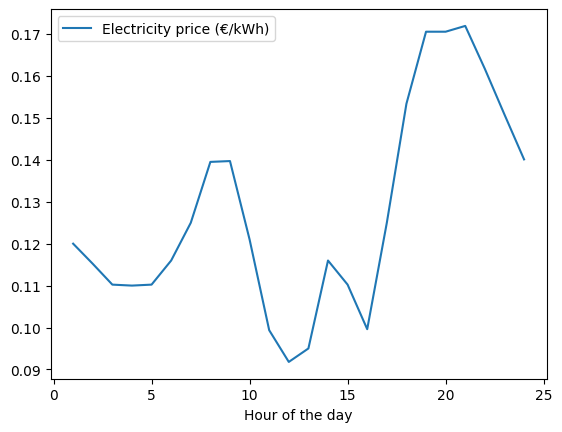

In [3]:
# Global parameters
n = 24   # number of hours (from 0 to n both included)

# Input generators data
hours = np.linspace(1,n,n) # 1 data point per hour starting from 0 to n, both included
e_price = np.array([120.00,   115.20,   110.23,   110.00,   110.23,   115.98,   124.98,   139.51,   139.71,   121.00,    99.36,    91.79,    95.00,   115.98,   110.23,    99.60,   124.98,   153.38,   170.57,   170.57,   171.95,   161.71,   150.82,   140.11,])/1e3 # in €/kWh


# Input data plot
plt.figure()
plt.plot(hours,e_price,label="Electricity price (€/kWh)")
plt.legend()
plt.xlabel('Hour of the day')
plt.show()

We consider the French EV Renault Zoe (https://en.wikipedia.org/wiki/Renault_Zoe). The lithium-ion battery has a capacity $C$ of 52 kWh. The charging voltage $U$ is 400 V.

This EV is available for charging the whole day. Its initial state of charge (SoC) is 30\% and the owner expects the battery to be charged at 85\% at the end of the period. The charger used at home has a nominal power of 22kW. For now, we consider a fixed efficiency of 95\%.

For each time step, the SoC of the battery can be evaluated as the SoC at the previous step, plus the percentage of capacity charged in the current slot:
$$SoC_{i+1} = SoC_i + E_i/C$$
Where $E_i$ is the amount of energy (kWh) charged during slot $i$. It can be computed using a simplified formula:
$$E_i = Eff_{charger} * I_i * U * dt$$
where $I_i$ is the charging current and $dt$ the length of a time step.

For technical constraints, the battery SoC should stay in the interval [0.2,0.95].

In [4]:
# Known data
C = 52 # capacity of the battery in kWh
U = 400 # Voltage in V
SoC_0 = 0.3 # Initial state of charge
SoC_f = 0.85 # Expected final state of charge
P_charger = 22 # maximal power of the charger (kW)
Eff_charger = 0.92 # efficiency of the charger
dt = 1 # time step in hour

## Optimization of charging

We want to minimize the cost of the charging for the next 24 hours while considering the price curve and satisfying the target SoC.

### 1. Define your decision variables and their domains:

In [5]:
# Solution by Joe El-Khoury, Akila Kulathunga, Céline Santus 
# LP: minimize the total cost of charging a battery while satisfying constraints
from scipy.optimize import minimize, LinearConstraint, Bounds, approx_fprime, NonlinearConstraint

# decision variable: energy charged per hour (x)
x0 = np.random.rand(24)* 0.95*22#energy_needed # initial values for energy charged per hour
bounds = Bounds(0, 22*0.95) # bounds for energy charged per hour
max_energy_per_hour = 22 * 0.95


### 2. Define the constraints to satisfy:

In [6]:
# constraint: total energy needed
energy_con = LinearConstraint(np.ones(24), 0, max_energy_per_hour)# energy_needed

# constraint: maximum energy that can be charged per hour
max_energy_con = LinearConstraint(np.ones(24), 0, max_energy_per_hour)

# constraints: limits on the state of charge (soc)
soc_init = LinearConstraint([[1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]],[0.3*52],[0.3*52])
soc_limit = LinearConstraint(np.eye(24), 0.2*52, 0.95*52) #soc at each hour
soc_last = LinearConstraint([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]],[0.85*52],[0.85*52])

### 3. Define your objective function. What is the class of your problem ? Solve it with a relevant algorithm:

/shared-libs/python3.9/py/lib/python3.9/site-packages/scipy/optimize/_minimize.py:569: RuntimeWarning: Method Nelder-Mead cannot handle constraints.
  warn('Method %s cannot handle constraints.' % method,
Energy charged per hour:  [4.61883776e-02 1.56074424e-01 1.05454142e-01 3.41620068e-03
 6.30073813e-01 3.21905558e-01 2.10844064e-01 2.97404805e+00
 3.33890993e-02 2.87630363e+00 3.46765062e+00 2.96497776e+00
 1.75973107e-01 1.93333472e+00 1.00047541e+00 2.09000000e+01
 7.95230089e-01 6.97434052e-01 1.50829464e+00 7.22648384e-03
 5.33474203e-02 0.00000000e+00 1.39147513e+00 5.12476673e-01]
Minimum cost to charge: € 4.991093227797552
Soc per hour:  [0.3, 0.3008882380301531, 0.30388966926616195, 0.305917633544349, 0.30598332971129694, 0.3181001338143426, 0.3242906253127898, 0.32834531885240065, 0.3855385505602828, 0.3861806486239441, 0.44149417987827744, 0.5081797686481366, 0.5651985717415622, 0.5685826699492283, 0.6057621838400039, 0.6250020955608115, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85

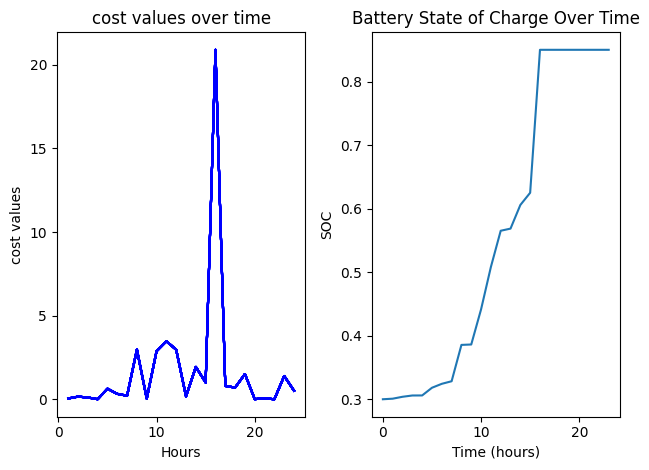

In [7]:
# Solution by Joe El-Khoury, Akila Kulathunga, Céline Santus 
from scipy.optimize import minimize, LinearConstraint, Bounds, approx_fprime, NonlinearConstraint
import numpy as np
efficiency = 0.95
def objective(x, prices):
    
    energy_charged_per_hour = x/efficiency # energy charged per hour corrected by the efficiency
    cost_per_hour = energy_charged_per_hour * prices # cost per hour
    total_cost = sum(cost_per_hour) # total cost
    return total_cost

def energy_constraint(x):
    return sum(x) - energy_needed

def soc_constraint(x):
    soc = [0.3]
    for i in range(23):
        soc_i = soc[i] + x[i]/52
        soc.append(min(max(soc_i,0.2),0.85))
    return soc 

prices = e_price # prices of electricity per kwh for each hour of the day

energy_needed = 52 * 0.85 # energy needed to charge the battery

bounds = Bounds(0, 22*0.95) # bounds for energy charged per hour
#energy_needed

# add constraint for max energy per hour
max_energy_per_hour = 22 * 0.95

#constraints for energy
energy_con = LinearConstraint(np.ones(24), 0, max_energy_per_hour)#energy_needed)
max_energy_con = LinearConstraint(np.ones(24), 0, max_energy_per_hour)
#max_energy_con2 = LinearConstraint(np.ones(24), 0, max_energy_per_hour)
#LinearConstraint
#constraints for soc
soc_init = LinearConstraint([[1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]],[0.3*52],[0.3*52])
soc_last = LinearConstraint([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]],[0.85*52],[0.85*52])
soc_limit = LinearConstraint(np.eye(24), 0.2*52, 0.95*52)

np.random.seed(11)
x0 = np.random.rand(24)* 0.95*22#energy_needed # initial values for energy charged per hour
result = minimize(objective, x0, args=(prices,), bounds=bounds, constraints=[energy_con,soc_init,soc_limit,soc_last, max_energy_con],method='Nelder-Mead')#,options={'disp': True,'tol':1e-9,'integrality':[0,24], 'maxiter':10000})
soc = soc_constraint(result.x)
print("Energy charged per hour: ",result.x )
print("Minimum cost to charge: €", result.fun)
print("Soc per hour: ", soc)
print(sum(result.x))

hours = np.linspace(1, len(result.x), len(result.x))
result.x.shape

# Plot the result values as a line graph with respect to the hour change
plt.subplot(1, 2, 1)
for i in range(24):
    plt.plot(hours, result.x, 'b-')#, label=f'column {i+1}')
plt.xlabel('Hours')
plt.ylabel('cost values')
plt.title('cost values over time')
plt.subplot(1, 2, 2)
plt.plot(soc)
plt.xlabel("Time (hours)")
plt.ylabel("SOC")
plt.title("Battery State of Charge Over Time")
plt.tight_layout()
plt.show()


## Varying charging efficiency

Previous assumptions are too basic to be realistics. In fact, the efficiency of the charger depends on the used rated power of the charger. From the some experiments, we get the following data:

| \% Power | Eff |
|:--------:|:----|
|  0.6     | 0.5 |
|  0.7     | 0.72|
|  0.8     | 0.9 |
|  0.85    | 0.95|
|  0.9     | 0.92 |
|  1       | 0.9|

The manufacturer recommands to use the charger with rated power over 60\%

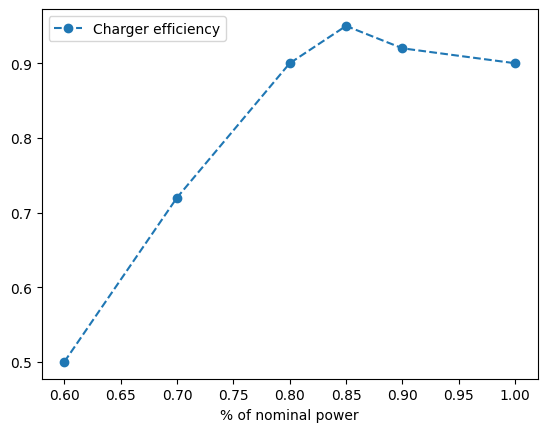

In [8]:
perP = np.array([0.6,0.7,0.8,0.85,0.9,1])
Eff = np.array([0.5,0.72,0.9,0.95,.92,0.9])

plt.figure()
plt.plot(perP,Eff,'o--',label="Charger efficiency")
plt.legend()
plt.xlabel('% of nominal power')
plt.show()

### 4. Use this information to update your modeling. Solve your new model:

/shared-libs/python3.9/py/lib/python3.9/site-packages/scipy/optimize/_minimize.py:569: RuntimeWarning: Method Nelder-Mead cannot handle constraints.
  warn('Method %s cannot handle constraints.' % method,
Energy charged per hour:  [2.35388773e-01 0.00000000e+00 4.78295527e-02 7.67522385e-05
 7.70475899e-01 5.34007728e-02 5.27710928e-02 1.51729555e-01
 1.12404525e-03 1.44229117e-01 2.08951211e+01 1.24034526e-01
 1.16790925e-02 1.42017454e+00 3.92830897e-02 2.91499122e-01
 4.81126320e-02 1.88292646e+01 3.86762773e-02 0.00000000e+00
 2.07391831e-03 0.00000000e+00 1.05161699e-03 1.46245154e-02]
Minimum cost to charge: € 6.149712260994642
Soc per hour:  [0.3, 0.30452670716732444, 0.30452670716732444, 0.30544650625705616, 0.30544798226164227, 0.320264826477102, 0.32129176441490415, 0.32230659312309645, 0.32522446918926334, 0.32524608544415956, 0.32801972231266235, 0.7298489746709291, 0.7322342540175989, 0.7324588519504192, 0.7597699008656654, 0.7605253448974268, 0.7661310972427622, 0.7670563

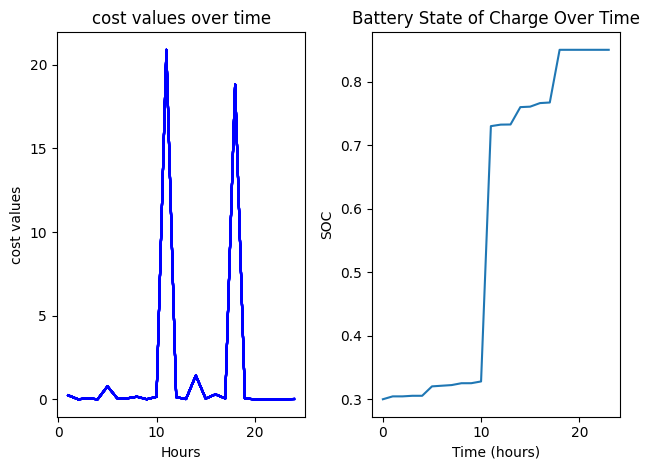

In [9]:
# solution 1:
from scipy.optimize import minimize, LinearConstraint, Bounds, approx_fprime, NonlinearConstraint
import numpy as np
import matplotlib.pyplot as plt
# efficiency = 0.95


def charging_efficiency(power):
    power = np.asarray(power)
    efficiency = np.zeros_like(power)
    mask = np.less_equal(power, 0.6)
    efficiency[mask] = 0.5
    mask = np.logical_and(np.greater(power, 0.6), np.less_equal(power, 0.7))
    efficiency[mask] = (0.72 - 0.5) / (0.7 - 0.6) * (power[mask] - 0.6) + 0.5
    mask = np.logical_and(np.greater(power, 0.7), np.less_equal(power, 0.8))
    efficiency[mask] = (0.9 - 0.72) / (0.8 - 0.7) * (power[mask] - 0.7) + 0.72
    mask = np.logical_and(np.greater(power, 0.8), np.less_equal(power, 0.85))
    efficiency[mask] = (0.95 - 0.9) / (0.85 - 0.8) * (power[mask] - 0.8) + 0.9
    mask = np.logical_and(np.greater(power, 0.85), np.less_equal(power, 0.9))
    efficiency[mask] = (0.92 - 0.95) / (0.9 - 0.85) * (power[mask] - 0.85) + 0.95
    mask = np.greater(power, 0.9)
    efficiency[mask] = 0.9
    return efficiency



def objective(x, prices):
    power = x/22
    efficiency = charging_efficiency(power)
    energy_charged_per_hour = x/efficiency # energy charged per hour corrected by the efficiency
    cost_per_hour = energy_charged_per_hour * prices # cost per hour
    total_cost = sum(cost_per_hour) # total cost
    return total_cost

def energy_constraint(x):
    return sum(x) - energy_needed

def soc_constraint(x):
    soc = [0.3]
    for i in range(23):
        soc_i = soc[i] + x[i]/52
        soc.append(min(max(soc_i,0.2),0.85))
    return soc 


prices = e_price # prices of electricity per kwh for each hour of the day

energy_needed = 52 * 0.85 # energy needed to charge the battery

bounds = Bounds(0, 22*0.95) # bounds for energy charged per hour
#energy_needed

# add constraint for max energy per hour
max_energy_per_hour = 22 * 0.95

#constraints for energy
energy_con = LinearConstraint(np.ones(24), 0, max_energy_per_hour)#energy_needed)
max_energy_con = LinearConstraint(np.ones(24), 0, max_energy_per_hour)
#max_energy_con2 = LinearConstraint(np.ones(24), 0, max_energy_per_hour)
#LinearConstraint
#constraints for soc
soc_init = LinearConstraint([[1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]],[0.3*52],[0.3*52])
soc_last = LinearConstraint([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]],[0.85*52],[0.85*52])
soc_limit = LinearConstraint(np.eye(24), 0.2*52, 0.95*52)

np.random.seed(64)
x0 = np.random.rand(24)* 0.95*22#energy_needed # initial values for energy charged per hour
result = minimize(objective, x0, args=(prices,), bounds=bounds, constraints=[energy_con,soc_init,soc_limit,soc_last, max_energy_con],method='Nelder-Mead')#,options={'disp': True,'tol':1e-9,'integrality':[0,24], 'maxiter':10000})
soc = soc_constraint(result.x)
print("Energy charged per hour: ",result.x )
print("Minimum cost to charge: €", result.fun)
print("Soc per hour: ", soc)
print(sum(result.x))


hours = np.linspace(1, len(result.x), len(result.x))
result.x.shape
# Plot the result values as a line graph with respect to the hour change
plt.subplot(1, 2, 1)
for i in range(24):
    plt.plot(hours, result.x, 'b-')#, label=f'column {i+1}')

plt.xlabel('Hours')
plt.ylabel('cost values')
plt.title('cost values over time')
plt.subplot(1, 2, 2)
plt.plot(soc)
plt.xlabel("Time (hours)")
plt.ylabel("SOC")
plt.title("Battery State of Charge Over Time")
plt.tight_layout()
plt.show()


## Vehicle to grid mode

EVs can store a big amount of energy and in some cases it can be used as a temporary storage for electricity to re-inject it in the power network. We call this the vehicle to grid (V2G) on the contrary to the classical grid to vehicle (G2V) mode. The fixed price for V2G is 0.125 €/KWh and the charger efficiency is equivalent in G2V and V2G mode.

### Define a new model to define wether the battery is charged or discharged to minimize the cost:

89
6.173491676559632
143
5.976889870349628
Minimum cost: 10.88477369401004
Schedule: [ 1.22232779e+01 -2.49376422e+00  1.26411765e-05  3.09357747e-08
  1.88663214e-05 -1.86210621e+00  1.09793697e+00  8.91626386e-06
 -8.85057138e-01  7.78760425e-01  8.17883665e+00  1.55535284e+01
  4.98618757e+00  2.98985071e+00 -3.23547268e+00  7.04059809e+00
 -7.87181479e-02  6.25196877e+00  7.26008897e-01 -3.89688829e-06
  1.26287650e+00  1.38864353e+01  1.17954236e+00  4.50892414e+00]
72.10965078700644


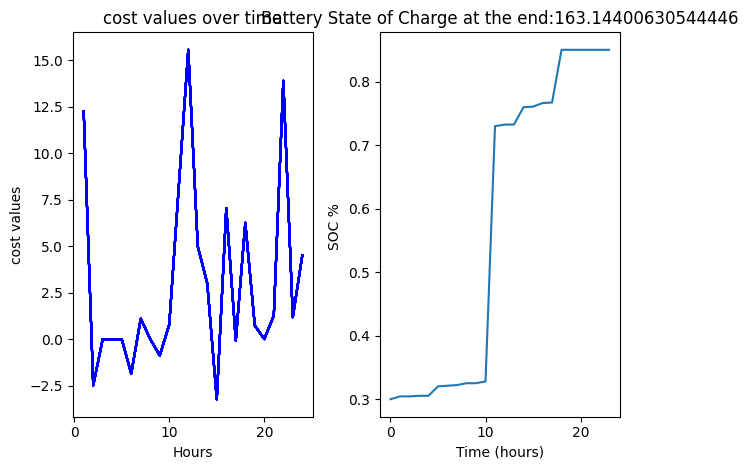

In [15]:
from scipy.optimize import minimize

# define the battery capacity and efficiency
capacity = 52 # in kWh
# efficiency = 0.95 # charging efficiency

# define the discharge rate and cost
discharge_rate = 0.125 # in €/kWh

# define the initial and final state of charge
initial_soc = 0.3
final_soc = 0.85
min_soc = 0.2

# define the list of charging costs (in €/kWh) for each hour
charging_costs = e_price # 24 values

# define the nominal power of the charger
nominal_power = 22 # in kW

# define the power rating percentage
# power_rating = 0.8 # 80% of the nominal power

def charging_efficiency(power):
    power = np.asarray(power)
    efficiency = np.zeros_like(power)
    mask = np.less_equal(power, 0.6)
    efficiency[mask] = 0.5
    mask = np.logical_and(np.greater(power, 0.6), np.less_equal(power, 0.7))
    efficiency[mask] = (0.72 - 0.5) / (0.7 - 0.6) * (power[mask] - 0.6) + 0.5
    mask = np.logical_and(np.greater(power, 0.7), np.less_equal(power, 0.8))
    efficiency[mask] = (0.9 - 0.72) / (0.8 - 0.7) * (power[mask] - 0.7) + 0.72
    mask = np.logical_and(np.greater(power, 0.8), np.less_equal(power, 0.85))
    efficiency[mask] = (0.95 - 0.9) / (0.85 - 0.8) * (power[mask] - 0.8) + 0.9
    mask = np.logical_and(np.greater(power, 0.85), np.less_equal(power, 0.9))
    efficiency[mask] = (0.92 - 0.95) / (0.9 - 0.85) * (power[mask] - 0.85) + 0.95
    mask = np.greater(power, 0.9)
    efficiency[mask] = 0.9
    return efficiency


efficiencies = {0.6: 0.5, 0.7: 0.72, 0.8: 0.9 , 0.85:0.95, 0.9:0.92, 1:0.9}
default_power_rating = 0.6



# define the function to minimize
def cost_function(x):
    # x is an array of 24 values representing the amount of energy charged/discharged during each hour
    # x[i] is the energy charged/discharged during hour i
    soc = initial_soc
    total_cost = 0
    for i in range(24):
        # find the power rating for the current hour
        
        if x[i] == 0:
            power_rating = default_power_rating
        else:
            power_rating = x[i]/nominal_power
        # round the power rating to the nearest value in the dictionary
        #power_rating = min(efficiencies, key=lambda x: abs(x-power_rating))
        # find the corresponding efficiency
        #efficiency = efficiencies[power_rating]
        power_rating= x[i]/nominal_power
        efficiency= charging_efficiency(power_rating)
        # charging
        if x[i] >0:#< 0.85*52 and x[i]<0.95*52:
            soc += x[i]/(efficiency*52)
            total_cost += x[i]*charging_costs[i]
        # discharging
        else:
            soc += x[i]/52
            total_cost += -x[i]*discharge_rate
        if soc>final_soc:
            soc = final_soc
        if soc<min_soc:
            soc = min_soc
    return total_cost

# define the constraints
bounds = [(-22*0.95, 22*0.95)]*24
constraints = {'type': 'eq', 'fun': lambda x: capacity*initial_soc - sum(x)}

min_value = float('inf') #initialize minimum value as infinity
min_iter = 0
for i in range(89, 1001):
    # x0= 24*[0]
    np.random.seed(i)
    x0 = np.random.rand(24)*22*0.95#energy_needed # initial values for energy charged per hour
    result = minimize(cost_function, x0, bounds=bounds, constraints=constraints, method='Nelder-Mead')
    if result.fun < min_value and sum(result.x) <= 50 and sum(result.x) >= 39: 
        min_value = result.fun
        min_iter = i
        print(min_iter)
        print(min_value)

# minimize the cost
# np.random.seed(624)
# x0 = np.random.rand(24)*22*0.95# initial values for energy charged per hour
# result = minimize(cost_function, x0, bounds=bounds, constraints=constraints, method='Nelder-mead')
# print the results
print('Minimum cost:', result.fun)
print('Schedule:', result.x)
print(sum(result.x))
hours = np.linspace(1, len(result.x), len(result.x))
result.x.shape
# Plot the matrix values as a line graph with respect to the hour change
plt.subplot(1, 2, 1)
for i in range(24):
    plt.plot(hours, result.x, 'b-')#, label=f'column {i+1}')
plt.xlabel('Hours')
plt.ylabel('cost values')
plt.title('cost values over time')
plt.subplot(1, 2, 2)
plt.plot(soc)
plt.xlabel("Time (hours)")
plt.ylabel("SOC % ")
string = "%"
plt.title("Battery State of Charge at the end:{}".format((sum(result.x)/(0.85*52))*100,string))
plt.tight_layout()
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4b2f9272-6e87-49c6-96e7-af74798e5a33' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>